In [1]:
import json
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
def process_string(string):
    string = re.sub('[^A-Za-z0-9\-\/ ]+', ' ', string).split()
    return [y.strip() for y in string]

In [3]:
with open('pos-data-v3.json','r') as fopen:
    dataset = json.load(fopen)

In [4]:
texts, labels = [], []
for i in dataset:
    try:
        texts.append(process_string(i[0])[0].lower())
        labels.append(i[-1])
    except Exception as e:
        print(e, i)

list index out of range ['%', '%', 'SYM']
list index out of range ['%', '%', 'SYM']
list index out of range ['*', '*', 'SYM']
list index out of range ['뭘봐', '뭘봐', 'PROPN']
list index out of range ['%', '%', 'SYM']
list index out of range ['ひ', 'ひ', 'PROPN']
list index out of range ['ヒ', 'ヒ', 'PROPN']
list index out of range ['形聲', '形聲', 'NOUN']
list index out of range ['°', '°', 'SYM']
list index out of range ['汉', '汉', 'PROPN']
list index out of range ['东', '东', 'PROPN']
list index out of range ['王', '王', 'PROPN']
list index out of range ['（', '（', 'PROPN']
list index out of range ['伊', '伊', 'PROPN']
list index out of range ['）', '）', 'PROPN']
list index out of range ['ȝ', 'ȝ', 'PROPN']
list index out of range ['%', '%', 'SYM']
list index out of range ['°', '°', 'SYM']
list index out of range ['%', '%', 'SYM']
list index out of range ["'", '_', 'PROPN']
list index out of range ['碁', '碁', 'NOUN']
list index out of range ['囲碁', '囲碁', 'NOUN']
list index out of range ['*', '*', 'SYM']
lis

In [5]:
word2idx = {'PAD': 0,'NUM':1,'UNK':2}
tag2idx = {'PAD': 0}
char2idx = {'PAD': 0}
word_idx = 3
tag_idx = 1
char_idx = 1

def parse_XY(texts, labels):
    global word2idx, tag2idx, char2idx, word_idx, tag_idx, char_idx
    X, Y = [], []
    for no, text in enumerate(texts):
        tag = labels[no]
        for c in text:
            if c not in char2idx:
                char2idx[c] = char_idx
                char_idx += 1
        if tag not in tag2idx:
            tag2idx[tag] = tag_idx
            tag_idx += 1
        Y.append(tag2idx[tag])
        text = text.lower()
        if text not in word2idx:
            word2idx[text] = word_idx
            word_idx += 1
        X.append(word2idx[text])
    return X, np.array(Y)

In [6]:
X, Y = parse_XY(texts, labels)
idx2word={idx: tag for tag, idx in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [7]:
seq_len = 50
def iter_seq(x):
    return np.array([x[i: i+seq_len] for i in range(0, len(x)-seq_len, 1)])

def to_train_seq(*args):
    return [iter_seq(x) for x in args]

In [8]:
X_seq, Y_seq = to_train_seq(X, Y)
X_seq.shape

(103367, 50)

In [9]:
import json
with open('crf-lstm-bidirectional-pos.json','w') as fopen:
    fopen.write(json.dumps({'idx2tag':idx2tag,'idx2word':idx2word,
           'word2idx':word2idx,'tag2idx':tag2idx}))

In [10]:
from keras.utils import to_categorical
Y_seq_3d = [to_categorical(i, num_classes=len(tag2idx)) for i in Y_seq]

Using TensorFlow backend.


In [11]:
from sklearn.cross_validation import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_seq, Y_seq_3d, test_size=0.1)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
import keras
print(keras.__version__)

2.2.2


In [13]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.backend.tensorflow_backend import set_session
set_session(tf.InteractiveSession())

In [14]:
max_len = seq_len
input_word = Input(shape=(None,))
model = Embedding(input_dim=len(word2idx) + 1, output_dim=128, mask_zero=True)(input_word)
model = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(len(tag2idx))
out = crf(model)

In [15]:
model = Model(input_word, out)

In [16]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2493952   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 50)          6450      
_________________________________________________________________
crf_1 (CRF)                  (None, None, 16)          1104      
Total params: 2,600,322
Trainable params: 2,600,322
Non-trainable params: 0
_________________________________________________________________


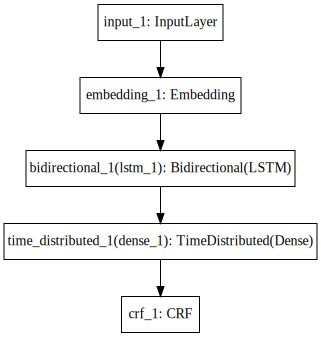

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
history = model.fit(train_X, np.array(train_Y), batch_size=32, epochs=2,
                    validation_split=0.1, verbose=1)

Train on 83727 samples, validate on 9303 samples
Epoch 1/2
83727/83727 [==============================] - 534s 6ms/step - loss: 0.1762 - acc: 0.9450 - val_loss: 0.0091 - val_acc: 0.9973
Epoch 2/2
83727/83727 [==============================] - 408s 5ms/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.0039 - val_acc: 0.9987


In [20]:
predicted=model.predict(test_X,verbose=1)

10337/10337 [==============================] - 13s 1ms/step


In [21]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
    
pred_labels = pred2label(predicted)
test_labels = pred2label(test_Y)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_labels).ravel(), np.array(pred_labels).ravel()))

             precision    recall  f1-score   support

        ADJ       1.00      1.00      1.00     22427
        ADP       1.00      1.00      1.00     59872
        ADV       1.00      1.00      1.00     23826
        AUX       1.00      1.00      1.00      5226
      CCONJ       1.00      1.00      1.00     18472
        DET       1.00      1.00      1.00     20202
       NOUN       1.00      1.00      1.00    135690
        NUM       1.00      1.00      1.00     21572
       PART       1.00      1.00      1.00      2934
       PRON       1.00      1.00      1.00     23867
      PROPN       1.00      1.00      1.00    112922
      SCONJ       1.00      1.00      1.00      7318
        SYM       1.00      1.00      1.00      1337
       VERB       1.00      1.00      1.00     61009
          X       0.99      0.98      0.99       176

avg / total       1.00      1.00      1.00    516850



In [23]:
model.save_weights('crf-lstm-bidirectional-pos.h5')